In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline

In [2]:
with open("/Volumes/thesis-data/dtype_dict.json", "r") as d:
    dtypes = json.load(d)


In [3]:
main = pd.read_csv(
    "/Volumes/thesis-data/cwmtaf.csv",
    dtype=dtypes,
    parse_dates=["ADMDATE", "DISCDATE", "PERIOD"],
)


In [35]:
dist_results = {"expon": 1.32*1e-6, "lognorm": 0.01}

l = max(dist_results.items(), key=lambda item: item[1])
l

('lognorm', 0.01)

In [86]:
class Distribution(object):
    def __init__(self, dist_names=None):

        if not dist_names:
            raise ValueError("Must specify which distributions to fit.")

        self.dist_names = dist_names
        self.fitted = False

    def fit(self, data):

        dist_name, dist_params, p_value = self._get_results(data)

        self.name = dist_name
        self.params = dist_params
        self.p_value = p_value

        self.fitted = True
        return self.name, self.params, self.p_value

    def _get_results(self, data):

        dist_results, dist_params = [], {}
        for dist_name in self.dist_names:

            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(data)
            dist_params[dist_name] = params

            _, p_value = scipy.stats.kstest(data, dist_name, args=params)
            dist_results.append((dist_name, p_value))

        name, p_value = max(dist_results, key=lambda item: item[1])
        params = dist_params[name]

        return name, params, p_value
    
    def sample(self, n):

        if self.fitted:
            dist = getattr(scipy.stats, self.name)
            *args, loc, scale = self.params
            return dist.rvs(*args, loc=loc, scale=scale, size=n)

        else:
            raise ValueError("Must first run the `Distribution.fit()` method.")

    def plot(self, data, destination=None):

        fig, ax = plt.subplots(dpi=300)

        x = self.sample(n=len(data))

        ax.hist(x, alpha=0.5, bins=100, density=True, label="Fitted")
        ax.hist(data, alpha=0.5, bins=100, density=True, label="Actual")

        ax.legend(loc="upper right")

        if isinstance(destination, str):
            plt.savefig(destination, transparent=True)

        return fig, ax

In [87]:
dist = Distribution(["expon", "norm", "lognorm"])

data = main.groupby("SPELL_ID")["NetCost"].sum()
dist.fit(data)


('expon', (16.6119, 1900.366655268555), 0.0)

(0, 25000)

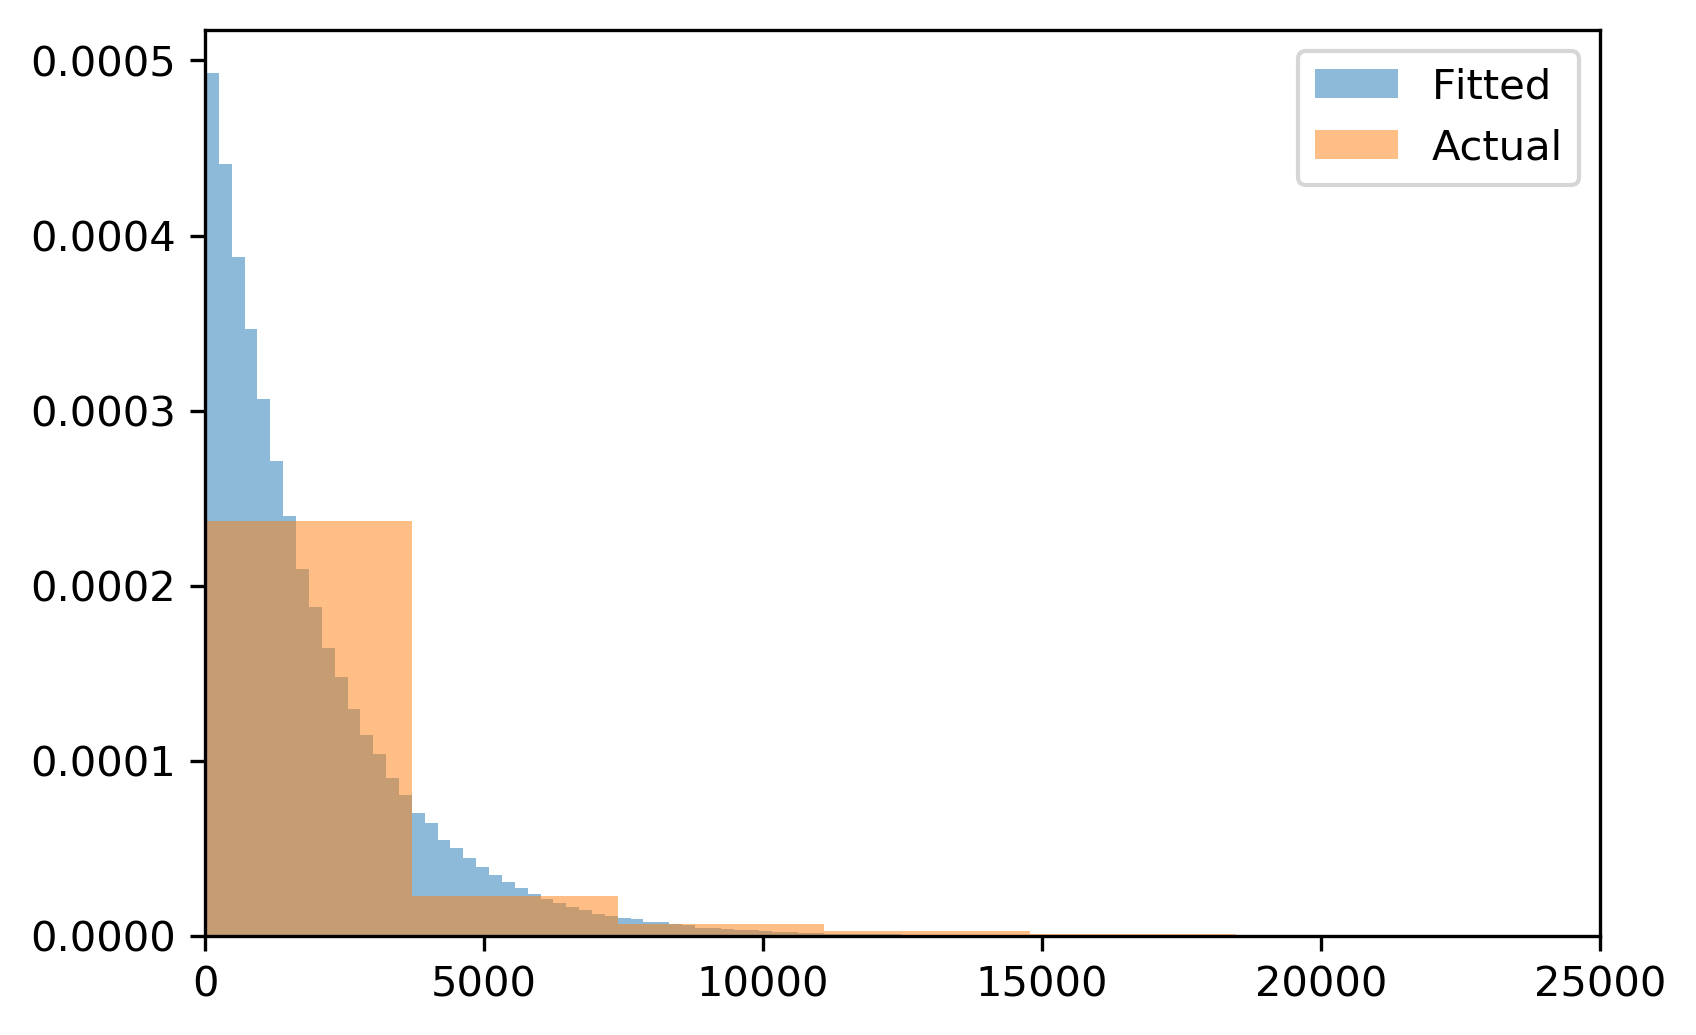

In [89]:
fig, ax = dist.plot(data)

ax.set_xlim(0, 25000)